In [280]:
import numpy as np
import pandas as pd

import pymc3 as pm
import theano.tensor as tt

from datetime import datetime, timedelta

%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib 
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.bottom'] = False
matplotlib.rcParams['axes.spines.left'] = False

PRIOR_N = 50
ELECTION_DATE = '2021-01-05'

In [281]:
def exp_decay(data_date, election_date):
    '''Weights polls with exponential decay setting 14 days before election at 0.5 weight'''
    # calculate time delta 
    td = (election_date - data_date).days
    
    # calculate the exponential decay
    return 0.5 ** (td / 30.)

In [282]:
# https://projects.fivethirtyeight.com/2020-ga-runoff-data/ga_runoff_polls_2020.csv
ga_runoff = pd.read_csv('data/ga_runoff_full.csv')
ga_runoff['startdate'] = pd.to_datetime(ga_runoff['startdate'])
ga_runoff['enddate'] = pd.to_datetime(ga_runoff['enddate'])
ga_runoff.head()

,candidate_name,startdate,enddate,pollster,samplesize,pct
0,David A. Perdue,2020-12-14,2020-12-16,Trafalgar Group,1064,50.0
1,Jon Ossoff,2020-12-14,2020-12-16,Trafalgar Group,1064,48.0
2,Kelly Loeffler,2020-12-14,2020-12-16,Trafalgar Group,1064,52.0
3,Raphael Warnock,2020-12-14,2020-12-16,Trafalgar Group,1064,46.0
4,David A. Perdue,2020-12-14,2020-12-16,Emerson College,605,51.0


In [283]:
candidates = ga_runoff['candidate_name'].unique().tolist()
candidates

['David A. Perdue', 'Jon Ossoff', 'Kelly Loeffler', 'Raphael Warnock']

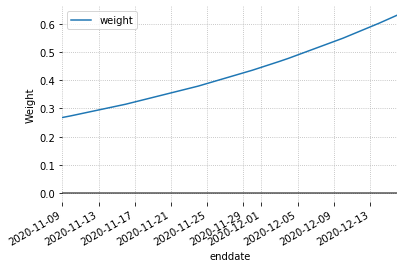

In [284]:
# weight the poll by end date
ga_runoff['weight'] = ga_runoff['enddate'].apply(exp_decay, args=(datetime.strptime(ELECTION_DATE, '%Y-%m-%d'),))
#ga_runoff['weight'] = 1
ga_runoff.plot(x='enddate', y='weight')
plt.grid(linestyle=':')
plt.ylabel('Weight')
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
#plt.legend(set_visible=False)
plt.savefig('imgs/exponential_decay.png')

In [285]:
# apply weight to sample size
ga_runoff['samplesize_weighted'] = ga_runoff['samplesize'] * ga_runoff['weight']
ga_runoff.head()

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight,samplesize_weighted
0,David A. Perdue,2020-12-14,2020-12-16,Trafalgar Group,1064,50.0,0.629961,670.277999
1,Jon Ossoff,2020-12-14,2020-12-16,Trafalgar Group,1064,48.0,0.629961,670.277999
2,Kelly Loeffler,2020-12-14,2020-12-16,Trafalgar Group,1064,52.0,0.629961,670.277999
3,Raphael Warnock,2020-12-14,2020-12-16,Trafalgar Group,1064,46.0,0.629961,670.277999
4,David A. Perdue,2020-12-14,2020-12-16,Emerson College,605,51.0,0.629961,381.126118


# Warnock v Loeffler

In [286]:
# Nov 3, 2020 results used as prior (total party support used as prior)
w_pct = 0.329 + 0.066 + 0.028 + 0.022 + 0.019 + 0.009 + 0.006
l_pct = 0.259 + 0.20 + 0.01 + 0.009 + 0.008 + 0.007

# normalize the split because the race is only between the two now
w_pct_norm = w_pct / (w_pct + l_pct)
l_pct_norm = l_pct / (w_pct + l_pct)

w_pct_norm, l_pct_norm

(0.492798353909465, 0.507201646090535)

In [287]:
warnock_polls = ga_runoff[ga_runoff.candidate_name == 'Raphael Warnock']
# only use most recent poll from pollsters that do multiple
warnock_polls = warnock_polls.sort_values('enddate').drop_duplicates('pollster', keep='last')
warnock_polls

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight,samplesize_weighted
29,Raphael Warnock,2020-11-08,2020-11-09,Remington Research Group,1450,48.0,0.267943,388.517880
27,Raphael Warnock,2020-11-10,2020-11-10,VCreek/AMG,300,45.6,0.274206,82.261873
28,Raphael Warnock,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,800,49.0,0.314980,251.984210
25,Raphael Warnock,2020-11-19,2020-11-24,RMG Research,1377,48.0,0.378929,521.785428
26,Raphael Warnock,2020-11-27,2020-11-30,SurveyUSA,583,52.0,0.435275,253.765489
23,Raphael Warnock,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,1250,47.0,0.477421,596.776002
11,Raphael Warnock,2020-12-10,2020-12-14,Wick,1500,48.0,0.601513,902.268777
15,Raphael Warnock,2020-12-14,2020-12-14,InsiderAdvantage,500,48.0,0.601513,300.756259
3,Raphael Warnock,2020-12-14,2020-12-16,Trafalgar Group,1064,46.0,0.629961,670.277999
7,Raphael Warnock,2020-12-14,2020-12-16,Emerson College,605,49.0,0.629961,381.126118


In [288]:
loeffler_polls = ga_runoff[ga_runoff.candidate_name == 'Kelly Loeffler']
# only use most recent poll from pollsters that do multiple
loeffler_polls = loeffler_polls.sort_values('enddate').drop_duplicates('pollster', keep='last')
loeffler_polls

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight,samplesize_weighted
35,Kelly Loeffler,2020-11-08,2020-11-09,Remington Research Group,1450,49.0,0.267943,388.517880
33,Kelly Loeffler,2020-11-10,2020-11-10,VCreek/AMG,300,49.5,0.274206,82.261873
34,Kelly Loeffler,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,800,48.0,0.314980,251.984210
31,Kelly Loeffler,2020-11-19,2020-11-24,RMG Research,1377,46.0,0.378929,521.785428
32,Kelly Loeffler,2020-11-27,2020-11-30,SurveyUSA,583,45.0,0.435275,253.765489
22,Kelly Loeffler,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,1250,46.0,0.477421,596.776002
10,Kelly Loeffler,2020-12-10,2020-12-14,Wick,1500,50.0,0.601513,902.268777
14,Kelly Loeffler,2020-12-14,2020-12-14,InsiderAdvantage,500,49.0,0.601513,300.756259
2,Kelly Loeffler,2020-12-14,2020-12-16,Trafalgar Group,1064,52.0,0.629961,670.277999
6,Kelly Loeffler,2020-12-14,2020-12-16,Emerson College,605,51.0,0.629961,381.126118


In [289]:
poll_normalizer = warnock_polls[['pollster', 'pct', 'enddate']].merge(loeffler_polls[['pollster', 'pct', 'enddate']], on=['pollster', 'enddate'])
poll_normalizer['normalizer'] = poll_normalizer['pct_x'] + poll_normalizer['pct_y']
poll_normalizer['pct_x'] /= poll_normalizer['normalizer']
poll_normalizer['pct_y'] /= poll_normalizer['normalizer']
poll_normalizer

,pollster,pct_x,enddate,pct_y,normalizer
0,Remington Research Group,0.494845,2020-11-09,0.505155,97.0
1,VCreek/AMG,0.479495,2020-11-10,0.520505,95.1
2,Opinion Savvy/InsiderAdvantage,0.505155,2020-11-16,0.494845,97.0
3,RMG Research,0.510638,2020-11-24,0.489362,94.0
4,SurveyUSA,0.536082,2020-11-30,0.463918,97.0
5,Fabrizio Ward/ Hart Research Associates,0.505376,2020-12-04,0.494624,93.0
6,Wick,0.489796,2020-12-14,0.510204,98.0
7,InsiderAdvantage,0.494845,2020-12-14,0.505155,97.0
8,Trafalgar Group,0.469388,2020-12-16,0.530612,98.0
9,Emerson College,0.490000,2020-12-16,0.510000,100.0


In [290]:
# add in the normalized values to warnock polls
for _, norm_row in poll_normalizer.iterrows():
    _date, _pollster, _pct = norm_row['enddate'], norm_row['pollster'], norm_row['pct_x']
    warnock_polls.loc[(warnock_polls.enddate == _date) & (warnock_polls.pollster == _pollster), 'pct'] = _pct
    
warnock_polls['num_votes'] = warnock_polls['samplesize_weighted'] * warnock_polls['pct']
warnock_polls

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight,samplesize_weighted,num_votes
29,Raphael Warnock,2020-11-08,2020-11-09,Remington Research Group,1450,0.494845,0.267943,388.517880,192.256271
27,Raphael Warnock,2020-11-10,2020-11-10,VCreek/AMG,300,0.479495,0.274206,82.261873,39.444179
28,Raphael Warnock,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,800,0.505155,0.314980,251.984210,127.290993
25,Raphael Warnock,2020-11-19,2020-11-24,RMG Research,1377,0.510638,0.378929,521.785428,266.443623
26,Raphael Warnock,2020-11-27,2020-11-30,SurveyUSA,583,0.536082,0.435275,253.765489,136.039231
23,Raphael Warnock,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,1250,0.505376,0.477421,596.776002,301.596474
11,Raphael Warnock,2020-12-10,2020-12-14,Wick,1500,0.489796,0.601513,902.268777,441.927564
15,Raphael Warnock,2020-12-14,2020-12-14,InsiderAdvantage,500,0.494845,0.601513,300.756259,148.827840
3,Raphael Warnock,2020-12-14,2020-12-16,Trafalgar Group,1064,0.469388,0.629961,670.277999,314.620285
7,Raphael Warnock,2020-12-14,2020-12-16,Emerson College,605,0.490000,0.629961,381.126118,186.751798


In [291]:
# group by pollster
warnock_pollsters = (
    warnock_polls[['pollster', 'samplesize_weighted', 'num_votes']]
    .groupby('pollster')
    .agg(np.sum)
)
warnock_pollsters

,samplesize_weighted,num_votes
pollster,,
Emerson College,381.126118,186.751798
Fabrizio Ward/ Hart Research Associates,596.776002,301.596474
InsiderAdvantage,300.756259,148.827840
Opinion Savvy/InsiderAdvantage,251.984210,127.290993
RMG Research,521.785428,266.443623
Remington Research Group,388.517880,192.256271
SurveyUSA,253.765489,136.039231
Trafalgar Group,670.277999,314.620285
VCreek/AMG,82.261873,39.444179


In [292]:
# tune n for how much we want the model to 
alpha = int(w_pct_norm * PRIOR_N)
beta = PRIOR_N - alpha

alpha, beta

(24, 26)

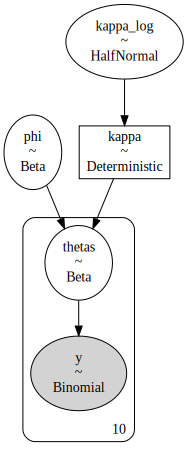

In [293]:
with pm.Model() as warnock_model:
    
    phi = pm.Beta('phi', alpha=alpha, beta=beta)

    kappa_log = pm.HalfNormal('kappa_log', sigma=1)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta(
        'thetas', 
        alpha=phi*kappa, 
        beta=(1.0-phi)*kappa, 
        shape=len(warnock_pollsters)
    )
    
    
    y = pm.Binomial(
        'y', 
        n=warnock_pollsters['samplesize_weighted'], 
        p=thetas, 
        observed=warnock_pollsters['num_votes']
    )
    
pm.model_to_graphviz(warnock_model)

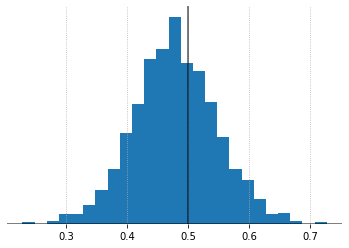

In [294]:
with warnock_model:
    warnock_prior = pm.sample_prior_predictive(samples=1000)
    
plt.hist(warnock_prior['phi'], bins=25)
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.grid(linestyle=':')
plt.yticks([])
plt.show()

In [295]:
with warnock_model:
    #step = pm.Metropolis()
    warnock_samples = pm.sample(2000, tune=5000, cores=4, target_accept=0.999) # target_accept=0.99
    #post_pred = pm.sample_posterior_predictive(samples, 200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, kappa_log, phi]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 47 seconds.


/home/flo/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


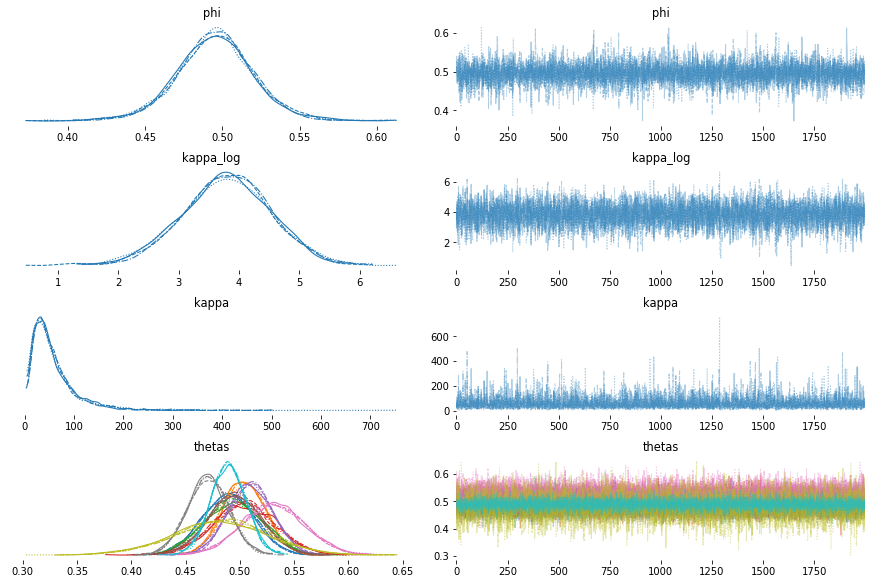

In [296]:
pm.traceplot(warnock_samples)
plt.show()

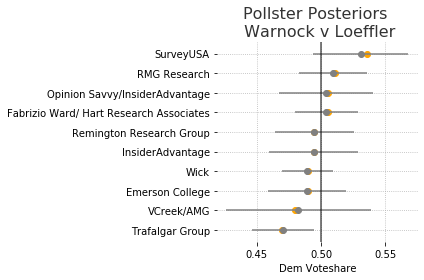

In [297]:
medians = []
errs = []
labels = []
for pollster_idx in range(warnock_samples['thetas'].shape[1]):
    _median = np.mean(warnock_samples['thetas'][:,pollster_idx])
    lower, _ = np.percentile(warnock_samples['thetas'][:,pollster_idx], (10, 90))
    err = _median - lower
    
    medians.append(_median)
    errs.append(err)
    labels.append(warnock_pollsters.index.tolist()[pollster_idx])
    
errs = [x for _,x in sorted(zip(medians, errs))]
labels = [x for _,x in sorted(zip(medians, labels))]
medians = sorted(medians)
#print(medians)

#medians, errs, labels
for idx, _median in enumerate(medians):
    plt.errorbar(x=_median, y=idx, xerr=errs[idx], fmt='o', color='gray')
for pollster_idx, pollster in enumerate(labels):
    plt.scatter(
        x=(
            warnock_pollsters[warnock_pollsters.index == pollster]['num_votes'] / 
            warnock_pollsters[warnock_pollsters.index == pollster]['samplesize_weighted']
        ), 
        y=pollster_idx, color='orange')
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.grid(linestyle=':')
plt.yticks(np.arange(len(warnock_pollsters)), labels)
#plt.xticks([0.46, 0.5, 0.54], ['R Advantage', 'Draw', 'D Advantage'])
plt.xlabel('Dem Voteshare')
plt.title('Pollster Posteriors \n Warnock v Loeffler', fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/wl_pollster-lean.png')

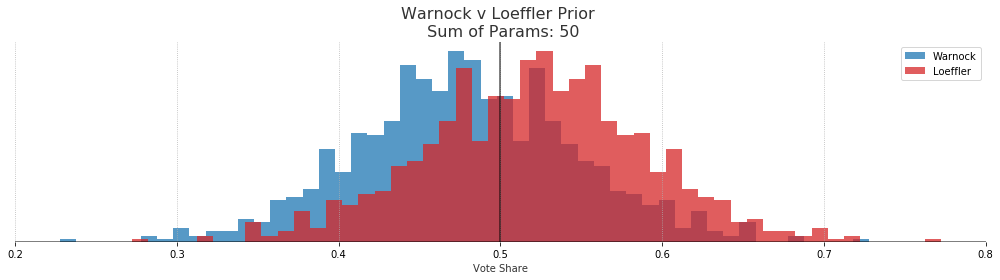

In [298]:
plt.figure(figsize=(14,4))
plt.hist(warnock_prior['phi'], color='tab:blue', alpha=0.75, bins=50, label='Warnock')
plt.hist(1. - warnock_prior['phi'], color='tab:red', alpha=0.75, bins=50, label='Loeffler')
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.xlabel('Vote Share', alpha=0.8)
plt.yticks([])
plt.xlim([0.2, 0.8])
plt.legend()
plt.grid(linestyle=':')
plt.title('Warnock v Loeffler Prior \n Sum of Params: {}'.format(PRIOR_N), fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/ga_wl_{}-priors.png'.format(PRIOR_N))

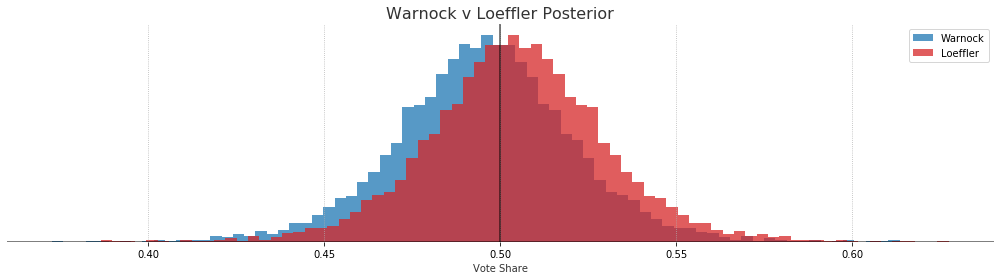

In [299]:
plt.figure(figsize=(14,4))
plt.hist(warnock_samples['phi'], color='tab:blue', alpha=0.75, bins=75, label='Warnock')
plt.hist(1. - warnock_samples['phi'], color='tab:red', alpha=0.75, bins=75, label='Loeffler')
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.xlabel('Vote Share', alpha=0.8)
plt.yticks([])
plt.legend()
plt.grid(linestyle=':')
plt.title('Warnock v Loeffler Posterior', fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/ga_wl_posteriors.png')

In [300]:
np.mean(warnock_samples['phi'] > 0.5), np.mean((1. - warnock_samples['phi']) > 0.5) 

(0.420875, 0.579125)

# Ossoff v Perdue

In [301]:
# Nov 3, 2020 results used as prior
o_pct = 0.479
p_pct = 0.497

# normalize the split because the race is only between the two now
o_pct_norm = o_pct / (o_pct + p_pct)
p_pct_norm = p_pct / (o_pct + p_pct)

o_pct_norm, p_pct_norm

(0.49077868852459017, 0.5092213114754098)

In [302]:
ossoff_polls = ga_runoff[ga_runoff.candidate_name == 'Jon Ossoff']
# only use most recent poll from pollsters that do multiple
ossoff_polls = ossoff_polls.sort_values('enddate').drop_duplicates('pollster', keep='last')
ossoff_polls

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight,samplesize_weighted
40,Jon Ossoff,2020-11-08,2020-11-09,Remington Research Group,1450,46.0,0.267943,388.517880
39,Jon Ossoff,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,800,49.0,0.314980,251.984210
37,Jon Ossoff,2020-11-19,2020-11-24,RMG Research,1377,48.0,0.378929,521.785428
38,Jon Ossoff,2020-11-27,2020-11-30,SurveyUSA,583,50.0,0.435275,253.765489
21,Jon Ossoff,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,1250,48.0,0.477421,596.776002
9,Jon Ossoff,2020-12-10,2020-12-14,Wick,1500,47.0,0.601513,902.268777
13,Jon Ossoff,2020-12-14,2020-12-14,InsiderAdvantage,500,49.0,0.601513,300.756259
1,Jon Ossoff,2020-12-14,2020-12-16,Trafalgar Group,1064,48.0,0.629961,670.277999
5,Jon Ossoff,2020-12-14,2020-12-16,Emerson College,605,49.0,0.629961,381.126118


In [303]:
perdue_polls = ga_runoff[ga_runoff.candidate_name == 'David A. Perdue']
# only use most recent poll from pollsters that do multiple
perdue_polls = perdue_polls.sort_values('enddate').drop_duplicates('pollster', keep='last')
perdue_polls

,candidate_name,startdate,enddate,pollster,samplesize,pct,weight,samplesize_weighted
45,David A. Perdue,2020-11-08,2020-11-09,Remington Research Group,1450,50.0,0.267943,388.517880
44,David A. Perdue,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,800,49.0,0.314980,251.984210
42,David A. Perdue,2020-11-19,2020-11-24,RMG Research,1377,47.0,0.378929,521.785428
43,David A. Perdue,2020-11-27,2020-11-30,SurveyUSA,583,48.0,0.435275,253.765489
20,David A. Perdue,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,1250,46.0,0.477421,596.776002
8,David A. Perdue,2020-12-10,2020-12-14,Wick,1500,51.0,0.601513,902.268777
12,David A. Perdue,2020-12-14,2020-12-14,InsiderAdvantage,500,48.0,0.601513,300.756259
0,David A. Perdue,2020-12-14,2020-12-16,Trafalgar Group,1064,50.0,0.629961,670.277999
4,David A. Perdue,2020-12-14,2020-12-16,Emerson College,605,51.0,0.629961,381.126118


In [304]:
poll_normalizer = ossoff_polls[['pollster', 'pct', 'enddate']].merge(perdue_polls[['pollster', 'pct', 'enddate']], on=['pollster', 'enddate'])
poll_normalizer['normalizer'] = poll_normalizer['pct_x'] + poll_normalizer['pct_y']
poll_normalizer['pct_x'] /= poll_normalizer['normalizer']
poll_normalizer['pct_y'] /= poll_normalizer['normalizer']
poll_normalizer

,pollster,pct_x,enddate,pct_y,normalizer
0,Remington Research Group,0.479167,2020-11-09,0.520833,96.0
1,Opinion Savvy/InsiderAdvantage,0.500000,2020-11-16,0.500000,98.0
2,RMG Research,0.505263,2020-11-24,0.494737,95.0
3,SurveyUSA,0.510204,2020-11-30,0.489796,98.0
4,Fabrizio Ward/ Hart Research Associates,0.510638,2020-12-04,0.489362,94.0
5,Wick,0.479592,2020-12-14,0.520408,98.0
6,InsiderAdvantage,0.505155,2020-12-14,0.494845,97.0
7,Trafalgar Group,0.489796,2020-12-16,0.510204,98.0
8,Emerson College,0.490000,2020-12-16,0.510000,100.0


In [305]:
# add in the normalized values to warnock polls
for _, norm_row in poll_normalizer.iterrows():
    _date, _pollster, _pct = norm_row['enddate'], norm_row['pollster'], norm_row['pct_x']
    ossoff_polls.loc[(ossoff_polls.enddate == _date) & (ossoff_polls.pollster == _pollster), 'pct'] = _pct
    
ossoff_polls['num_votes'] = ossoff_polls['samplesize_weighted'] * ossoff_polls['pct']
ossoff_polls


,candidate_name,startdate,enddate,pollster,samplesize,pct,weight,samplesize_weighted,num_votes
40,Jon Ossoff,2020-11-08,2020-11-09,Remington Research Group,1450,0.479167,0.267943,388.517880,186.164818
39,Jon Ossoff,2020-11-16,2020-11-16,Opinion Savvy/InsiderAdvantage,800,0.500000,0.314980,251.984210,125.992105
37,Jon Ossoff,2020-11-19,2020-11-24,RMG Research,1377,0.505263,0.378929,521.785428,263.638953
38,Jon Ossoff,2020-11-27,2020-11-30,SurveyUSA,583,0.510204,0.435275,253.765489,129.472188
21,Jon Ossoff,2020-11-30,2020-12-04,Fabrizio Ward/ Hart Research Associates,1250,0.510638,0.477421,596.776002,304.736682
9,Jon Ossoff,2020-12-10,2020-12-14,Wick,1500,0.479592,0.601513,902.268777,432.720740
13,Jon Ossoff,2020-12-14,2020-12-14,InsiderAdvantage,500,0.505155,0.601513,300.756259,151.928420
1,Jon Ossoff,2020-12-14,2020-12-16,Trafalgar Group,1064,0.489796,0.629961,670.277999,328.299428
5,Jon Ossoff,2020-12-14,2020-12-16,Emerson College,605,0.490000,0.629961,381.126118,186.751798


In [306]:
# group by pollster
ossoff_pollsters = (
    ossoff_polls[['pollster', 'samplesize_weighted', 'num_votes']]
    .groupby('pollster')
    .agg(np.sum)
)
ossoff_pollsters

,samplesize_weighted,num_votes
pollster,,
Emerson College,381.126118,186.751798
Fabrizio Ward/ Hart Research Associates,596.776002,304.736682
InsiderAdvantage,300.756259,151.928420
Opinion Savvy/InsiderAdvantage,251.984210,125.992105
RMG Research,521.785428,263.638953
Remington Research Group,388.517880,186.164818
SurveyUSA,253.765489,129.472188
Trafalgar Group,670.277999,328.299428
Wick,902.268777,432.720740


In [307]:
# tune n for how much we want the model to 
alpha = int(o_pct_norm * PRIOR_N)
beta = PRIOR_N - alpha

alpha, beta

(24, 26)

In [308]:
with pm.Model() as ossoff_model:
    
    phi = pm.Beta('phi', alpha=alpha, beta=beta)

    kappa_log = pm.HalfNormal('kappa_log', sigma=1)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta(
        'thetas', 
        alpha=phi*kappa, 
        beta=(1.0-phi)*kappa, 
        shape=len(ossoff_pollsters)
    )
    
    y = pm.Binomial(
        'y', 
        n=ossoff_pollsters['samplesize_weighted'], 
        p=thetas, 
        observed=ossoff_pollsters['num_votes']
    )

In [309]:
with ossoff_model:
    ossoff_prior = pm.sample_prior_predictive(samples=1000)

In [310]:
with ossoff_model:
    #step = pm.Metropolis()
    ossoff_samples = pm.sample(2000, tune=5000, cores=4, target_accept=0.999) # target_accept=0.99

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, kappa_log, phi]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 45 seconds.


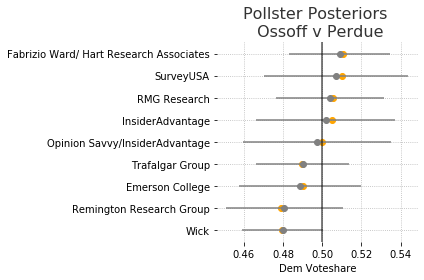

In [311]:
medians = []
errs = []
labels = []
for pollster_idx in range(ossoff_samples['thetas'].shape[1]):
    _median = np.mean(ossoff_samples['thetas'][:,pollster_idx])
    lower, _ = np.percentile(ossoff_samples['thetas'][:,pollster_idx], (10, 90))
    err = _median - lower
    
    medians.append(_median)
    errs.append(err)
    labels.append(ossoff_pollsters.index.tolist()[pollster_idx])
    
errs = [x for _,x in sorted(zip(medians, errs))]
labels = [x for _,x in sorted(zip(medians, labels))]
medians = sorted(medians)
#print(medians)

#medians, errs, labels
for idx, _median in enumerate(medians):
    plt.errorbar(x=_median, y=idx, xerr=errs[idx], fmt='o', color='gray')
    
for pollster_idx, pollster in enumerate(labels):
    plt.scatter(
        x=(
            ossoff_pollsters[ossoff_pollsters.index == pollster]['num_votes'] / 
            ossoff_pollsters[ossoff_pollsters.index == pollster]['samplesize_weighted']
        ), 
        y=pollster_idx, color='orange')
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.grid(linestyle=':')
plt.yticks(np.arange(len(ossoff_pollsters)), labels)
plt.xlabel('Dem Voteshare')
#plt.xticks([0.48, 0.5, 0.52], ['R Advantage', 'Draw', 'D Advantage'])
plt.title('Pollster Posteriors \n Ossoff v Perdue', fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/op_pollster-lean.png')

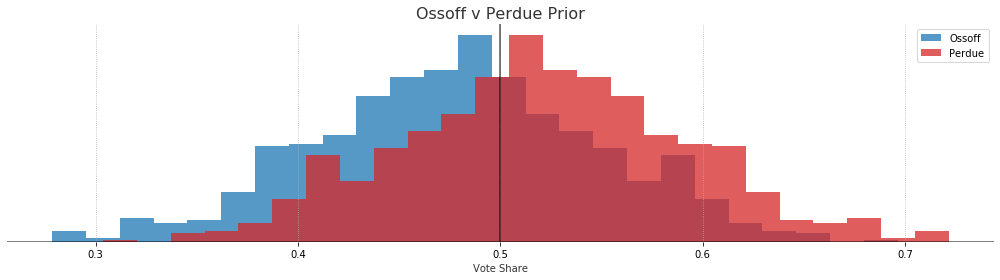

In [312]:
plt.figure(figsize=(14,4))
plt.hist(ossoff_prior['phi'], color='tab:blue', alpha=0.75, bins=25, label='Ossoff')
plt.hist(1. - ossoff_prior['phi'], color='tab:red', alpha=0.75, bins=25, label='Perdue')
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.xlabel('Vote Share', alpha=0.8)
plt.yticks([])
plt.legend()
plt.grid(linestyle=':')
plt.title('Ossoff v Perdue Prior', fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/ga_op_{}-priors.png'.format(PRIOR_N))

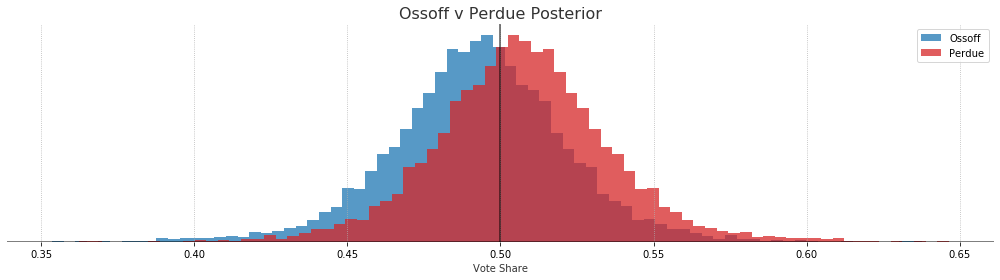

In [313]:
plt.figure(figsize=(14,4))
plt.hist(ossoff_samples['phi'], color='tab:blue', alpha=0.75, bins=75, label='Ossoff')
plt.hist(1. - ossoff_samples['phi'], color='tab:red', alpha=0.75, bins=75, label='Perdue')
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.xlabel('Vote Share', alpha=0.8)
plt.yticks([])
plt.legend()
plt.grid(linestyle=':')
plt.title('Ossoff v Perdue Posterior', fontsize=16, alpha=0.8)
plt.tight_layout()
plt.savefig('imgs/ga_op_posteriors.png')

In [314]:
np.mean(ossoff_samples['phi'] > 0.5), np.mean((1. - ossoff_samples['phi']) > 0.5) 

(0.393875, 0.606125)

In [316]:
0.5 ** (60 / 30.)

0.25